<a href="https://colab.research.google.com/github/sayakpaul/Supervised-Constrastive-Learning-in-TensorFlow-2/blob/master/Contrastive_Training_Pets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## References:
- https://arxiv.org/pdf/2004.11362.pdf
- https://towardsdatascience.com/contrastive-loss-for-supervised-classification-224ae35692e7

## Initial setup

In [1]:
import tensorflow as tf
print(tf.__version__)

2.2.0


In [2]:
!nvidia-smi

Tue May 26 09:35:22 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.82       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [0]:
!pip install --upgrade https://github.com/wandb/client/archive/feature/code-save.zip
import wandb
wandb.login()

In [0]:
!wget https://raw.githubusercontent.com/wangz10/contrastive_loss/master/losses.py

In [0]:
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tqdm.notebook import tqdm
from wandb.keras import WandbCallback
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np
import losses
import time

tf.random.set_seed(666)
np.random.seed(666)

tfds.disable_progress_bar()

## Pets dataset

In [0]:
train_ds, validation_ds = tfds.load(
    'cats_vs_dogs',
    split=['train[:85%]', 'train[85%:]'],
    as_supervised=True
)

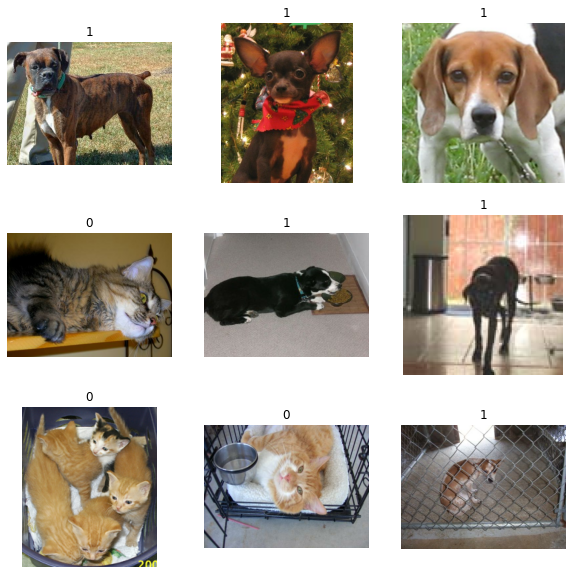

In [7]:
# Reference: https://keras.io/guides/transfer_learning/
plt.figure(figsize=(10, 10))
for i, (image, label) in enumerate(train_ds.take(9)):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image)
    plt.title(int(label))
    plt.axis('off')

## Data pipeline

In [0]:
IMG_SHAPE = 128
BS = 64
AUTO = tf.data.experimental.AUTOTUNE

@tf.function
def preprocess_image(image, label):
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.image.resize(image, (IMG_SHAPE, IMG_SHAPE))

    return (image, label)

train_ds = (
    train_ds
    .map(preprocess_image, num_parallel_calls=AUTO)
    .shuffle(100)
    .batch(BS)
    .prefetch(AUTO)
)

## Model building

In [0]:
# Reference: https://github.com/wangz10/contrastive_loss/blob/master/model.py
class UnitNormLayer(tf.keras.layers.Layer):
    '''Normalize vectors (euclidean norm) in batch to unit hypersphere.
    '''
    def __init__(self):
        super(UnitNormLayer, self).__init__()

    def call(self, input_tensor):
        norm = tf.norm(input_tensor, axis=1)
        return input_tensor / tf.reshape(norm, [-1, 1])

In [0]:
# Encoder Network
def encoder_net():
	inputs = Input((IMG_SHAPE, IMG_SHAPE, 3))
	normalization_layer = UnitNormLayer()

	encoder = tf.keras.applications.ResNet50(weights=None, include_top=False)
	encoder.trainable = True

	embeddings = encoder(inputs, training=True)
	embeddings = GlobalAveragePooling2D()(embeddings)
	norm_embeddings = normalization_layer(embeddings)

	encoder_network = Model(inputs, norm_embeddings)

	return encoder_network

# Projector Network
def projector_net():
	projector = tf.keras.models.Sequential([
		Dense(128, activation="relu"),
		UnitNormLayer()
	])

	return projector

## Running forward passes on a single image

In [11]:
encoder_r = encoder_net()
projector_z = projector_net()

images, _ = next(iter(train_ds))
r = encoder_r(tf.expand_dims(images[0], 0))
z = projector_z(r)

print(tf.shape(r))
print(tf.shape(z))

tf.Tensor([   1 2048], shape=(2,), dtype=int32)
tf.Tensor([  1 128], shape=(2,), dtype=int32)


## Training the encoder and the projector

In [0]:
optimizer = tf.keras.optimizers.Adam()

In [0]:
encoder_r = encoder_net()
projector_z = projector_net()

@tf.function
def train_step(images, labels):
	with tf.GradientTape() as tape:
		r = encoder_r(images, training=True)
		z = projector_z(r, training=True)
		loss = losses.max_margin_contrastive_loss(z, labels, metric='cosine')

	gradients = tape.gradient(loss, 
		encoder_r.trainable_variables + projector_z.trainable_variables)
	optimizer.apply_gradients(zip(gradients, 
		encoder_r.trainable_variables + projector_z.trainable_variables))

	return loss

In [0]:
wandb.init(project="scl", entity="authors", id="supervised-contrastive-crctd")
EPOCHS = 60
LOG_EVERY = 10
train_loss_results = []

start = time.time()
for epoch in tqdm(range(EPOCHS)):	
	epoch_loss_avg = tf.keras.metrics.Mean()
	
	for (images, labels) in train_ds:
		loss = train_step(images, labels)
		epoch_loss_avg.update_state(loss) 

	train_loss_results.append(epoch_loss_avg.result())
	wandb.log({"supervised_contrastive_loss": epoch_loss_avg.result()})

	if epoch % LOG_EVERY == 0:
		print("Epoch: {} Loss: {:.3f}".format(epoch, epoch_loss_avg.result()))

end = time.time()
wandb.log({"training_time": end - start})

with plt.xkcd():
    plt.plot(train_loss_results)
    plt.title("Supervised Contrastive Loss")
    plt.show()

## Supervised training

In [0]:
validation_ds = (
    validation_ds
    .map(preprocess_image, num_parallel_calls=AUTO)
    .shuffle(100)
    .batch(BS)
    .prefetch(AUTO)
)

In [0]:
def supervised_model():
	inputs = Input((IMG_SHAPE, IMG_SHAPE, 3))
	encoder_r.trainable = False

	r = encoder_r(inputs, training=False)
	outputs = Dense(1)(r)

	supervised_model = Model(inputs, outputs)

	return supervised_model

In [18]:
supervised_classifier = supervised_model()

supervised_classifier.compile(optimizer=tf.keras.optimizers.Adam(),
	loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
	metrics=[tf.keras.metrics.BinaryAccuracy()])

wandb.init(project="scl", entity="authors")
es = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=2,
	restore_best_weights=True, verbose=2)

supervised_classifier.fit(train_ds,
	validation_data=validation_ds,
	epochs=50,
	callbacks=[WandbCallback(), es])

Epoch 1/50
309/309 [==============================] - 44s 143ms/step - loss: 0.2342 - binary_accuracy: 0.9188 - val_loss: 0.2603 - val_binary_accuracy: 0.9008
Epoch 2/50
309/309 [==============================] - 43s 138ms/step - loss: 0.0967 - binary_accuracy: 0.9698 - val_loss: 0.2747 - val_binary_accuracy: 0.9014
Epoch 3/50
309/309 [==============================] - 43s 138ms/step - loss: 0.0860 - binary_accuracy: 0.9704 - val_loss: 0.2886 - val_binary_accuracy: 0.9008
Epoch 00003: early stopping


In [19]:
# Lowering the learning rate
supervised_classifier = supervised_model()

supervised_classifier.compile(optimizer=tf.keras.optimizers.Adam(lr=1e-4),
	loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
	metrics=[tf.keras.metrics.BinaryAccuracy()])

wandb.init(project="scl", entity="authors", id="low-lr")
es = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=2,
	restore_best_weights=True, verbose=2)

supervised_classifier.fit(train_ds,
	validation_data=validation_ds,
	epochs=50,
	callbacks=[WandbCallback(), es])

Epoch 1/50
309/309 [==============================] - 45s 147ms/step - loss: 0.5850 - binary_accuracy: 0.5262 - val_loss: 0.5164 - val_binary_accuracy: 0.7357
Epoch 2/50
309/309 [==============================] - 43s 141ms/step - loss: 0.4098 - binary_accuracy: 0.9144 - val_loss: 0.4071 - val_binary_accuracy: 0.8773
Epoch 3/50
309/309 [==============================] - 44s 142ms/step - loss: 0.3026 - binary_accuracy: 0.9555 - val_loss: 0.3434 - val_binary_accuracy: 0.8891
Epoch 4/50
309/309 [==============================] - 43s 140ms/step - loss: 0.2357 - binary_accuracy: 0.9620 - val_loss: 0.3061 - val_binary_accuracy: 0.8951
Epoch 5/50
309/309 [==============================] - 43s 138ms/step - loss: 0.1922 - binary_accuracy: 0.9638 - val_loss: 0.2841 - val_binary_accuracy: 0.8971
Epoch 6/50
309/309 [==============================] - 43s 139ms/step - loss: 0.1629 - binary_accuracy: 0.9652 - val_loss: 0.2712 - val_binary_accuracy: 0.8985
Epoch 7/50
309/309 [==========================

With more training for the encoder and the projector, we would have got better results. We did not use any augmentation policy for either of the trainings above, so including that would have also helped us enhance the performance. 

## Serialize the model weights to GCS

In [22]:
from google.colab import auth
auth.authenticate_user()

PROJECT_ID = "fast-ai-exploration" 
!gcloud config set project $PROJECT_ID

Updated property [core/project].


In [23]:
!gsutil mb gs://supervised-contrastive

Creating gs://supervised-contrastive/...


In [24]:
time_now = time.time()
encoder_r.save_weights("encoder_r_" + str(time_now) + ".h5")
projector_z.save_weights("projector_z" + str(time_now) + ".h5")

!gsutil -m cp -r *.h5 gs://supervised-contrastive/

Copying file://encoder_r_1590489813.9405909.h5 [Content-Type=application/octet-stream]...
Copying file://projector_z1590489813.9405909.h5 [Content-Type=application/octet-stream]...
\
Operation completed over 2 objects/91.2 MiB.                                     
